Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [12]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  final_test_dataset = save['final_test_dataset']
  final_test_labels = save['final_test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)
  print('Final Test set', final_test_dataset.shape, final_test_labels.shape)

Training set (100000, 28, 28) (100000,)
Validation set (5000, 28, 28) (5000,)
Test set (5000, 28, 28) (5000,)
Final Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
final_test_dataset, final_test_labels = reformat(final_test_dataset, final_test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Final Test set', final_test_dataset.shape,final_test_labels.shape)

Training set (100000, 784) (100000, 10)
Validation set (5000, 784) (5000, 10)
Test set (5000, 784) (5000, 10)
Final Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### First, let's introduce L2 regularization in the SGD logistic regression model

#### Logistic Regression Model Without Regularization

In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


def log_reg(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: tensor containing the weights
    biases: tensor containing the biases 
    ''' 
    return tf.add(tf.matmul(x,weights),biases)  
    

In [5]:
#Hyper-parameters

batch_size = 128
learning_rate = 0.5
num_steps = 3001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = log_reg(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.902328
Minibatch accuracy: 10.2%
Validation accuracy: 11.4%
Minibatch loss at step 500: 1.574934
Minibatch accuracy: 75.0%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 1.194848
Minibatch accuracy: 79.7%
Validation accuracy: 76.4%
Minibatch loss at step 1500: 1.137943
Minibatch accuracy: 75.8%
Validation accuracy: 77.6%
Minibatch loss at step 2000: 1.120408
Minibatch accuracy: 79.7%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 0.848964
Minibatch accuracy: 85.2%
Validation accuracy: 78.1%
Minibatch loss at step 3000: 1.092439
Minibatch accuracy: 72.7%
Validation accuracy: 77.8%
Test accuracy: 85.8%


#### Logistic Regression Model With Regularization

In [8]:
#Hyper-parameters

batch_size = 128
learning_rate = 0.5
num_steps = 3001
l2 = 0.002


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = log_reg(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(tf.add(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels),l2*tf.nn.l2_loss(weights)))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases + l2*tf.nn.l2_loss(weights))
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases + l2*tf.nn.l2_loss(weights))

In [9]:


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 23.309307
Minibatch accuracy: 10.2%
Validation accuracy: 13.3%
Minibatch loss at step 500: 2.975939
Minibatch accuracy: 74.2%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 1.237951
Minibatch accuracy: 86.7%
Validation accuracy: 80.3%
Minibatch loss at step 1500: 1.077300
Minibatch accuracy: 77.3%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 0.825405
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 2500: 0.643632
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.906068
Minibatch accuracy: 72.7%
Validation accuracy: 80.5%
Test accuracy: 87.9%


#### Neuronal Network Model Without Regularization

In [13]:
#First lets define a fucntion to represent the topology of our Neuronal Network:
#Topology: Multilayer Perceptron, 1 hidden layer with 1024 neurons and RELU activation function.

def mlp(x, weights, biases,l2=0):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    if(l2==0):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    else:
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['h1']))
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['out']))
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [90]:
#hyper-parameters

batch_size = 128
training_epochs = 3001
learning_rate = 0.5
display_step = 500
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp(tf_train_dataset, weights, biases)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(mlp(tf_test_dataset,weights,biases))
    

Graph Variables Initialized!
Minibatch loss at step 0: 316.791687012
Minibatch accuracy: 10.15625
Validation accuracy: 28.94
Minibatch loss at step 500: 17.3185119629
Minibatch accuracy: 80.46875
Validation accuracy: 79.82
Minibatch loss at step 1000: 15.0953474045
Minibatch accuracy: 82.03125
Validation accuracy: 78.84
Minibatch loss at step 1500: 5.28393745422
Minibatch accuracy: 82.8125
Validation accuracy: 81.52
Minibatch loss at step 2000: 2.11602020264
Minibatch accuracy: 91.40625
Validation accuracy: 80.76
Minibatch loss at step 2500: 11.7564563751
Minibatch accuracy: 80.46875
Validation accuracy: 79.98
Minibatch loss at step 3000: 3.33054542542
Minibatch accuracy: 80.46875
Validation accuracy: 81.0
Test accuracy: 87.7


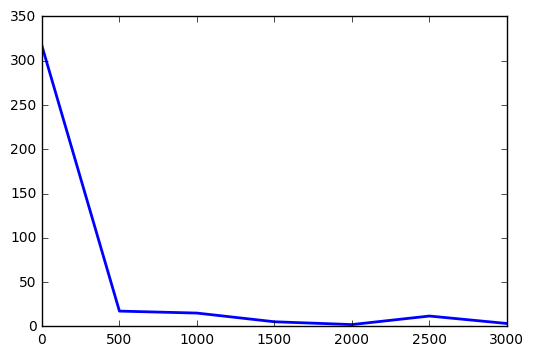

In [91]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

# Neuronal Network Model With L2 Regularization

In [14]:
#hyper-parameters

batch_size = 128
training_epochs = 3001
learning_rate = 0.5
display_step = 500
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels
l2 = 0.0001

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp(tf_train_dataset, weights, biases,l2)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp(tf_valid_dataset,weights,biases,l2))
    test_prediction = tf.nn.softmax(mlp(tf_test_dataset,weights,biases,l2))
    

Graph Variables Initialized!
Minibatch loss at step 0: 302.390563965
Minibatch accuracy: 14.0625
Validation accuracy: 23.2
Minibatch loss at step 500: 13.2263364792
Minibatch accuracy: 80.46875
Validation accuracy: 80.14
Minibatch loss at step 1000: 9.59216308594
Minibatch accuracy: 85.9375
Validation accuracy: 80.08
Minibatch loss at step 1500: 10.9576950073
Minibatch accuracy: 80.46875
Validation accuracy: 76.52
Minibatch loss at step 2000: 5.75169181824
Minibatch accuracy: 84.375
Validation accuracy: 82.36
Minibatch loss at step 2500: 4.61680936813
Minibatch accuracy: 91.40625
Validation accuracy: 81.96
Minibatch loss at step 3000: 3.21753931046
Minibatch accuracy: 81.25
Validation accuracy: 82.36
Test accuracy: 88.68


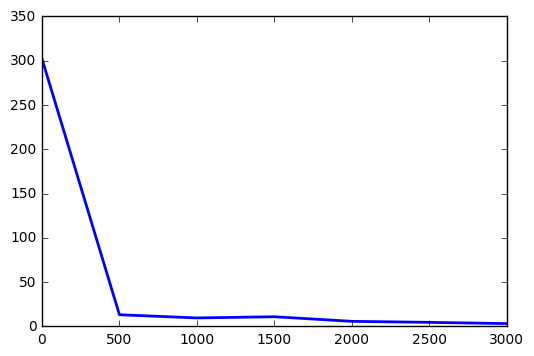

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [22]:
#hyper-parameters

batch_size = 128
training_epochs = 10
learning_rate = 0.5
display_step = 1
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels
l2 = 0.0001

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp(tf_train_dataset, weights, biases,l2)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp(tf_valid_dataset,weights,biases,l2))
    test_prediction = tf.nn.softmax(mlp(tf_test_dataset,weights,biases,l2))
    

Graph Variables Initialized!
Minibatch loss at step 0: 309.693603516
Minibatch accuracy: 7.8125
Validation accuracy: 21.08
Minibatch loss at step 1: 1481.8145752
Minibatch accuracy: 22.65625
Validation accuracy: 45.34
Minibatch loss at step 2: 763.462219238
Minibatch accuracy: 60.9375
Validation accuracy: 38.66
Minibatch loss at step 3: 959.102722168
Minibatch accuracy: 33.59375
Validation accuracy: 43.4
Minibatch loss at step 4: 958.191101074
Minibatch accuracy: 44.53125
Validation accuracy: 44.9
Minibatch loss at step 5: 518.217285156
Minibatch accuracy: 42.96875
Validation accuracy: 55.6
Minibatch loss at step 6: 226.894729614
Minibatch accuracy: 55.46875
Validation accuracy: 63.66
Minibatch loss at step 7: 222.007843018
Minibatch accuracy: 63.28125
Validation accuracy: 67.46
Minibatch loss at step 8: 258.156036377
Minibatch accuracy: 64.84375
Validation accuracy: 67.26
Minibatch loss at step 9: 165.40032959
Minibatch accuracy: 69.53125
Validation accuracy: 73.82
Test accuracy: 81.7

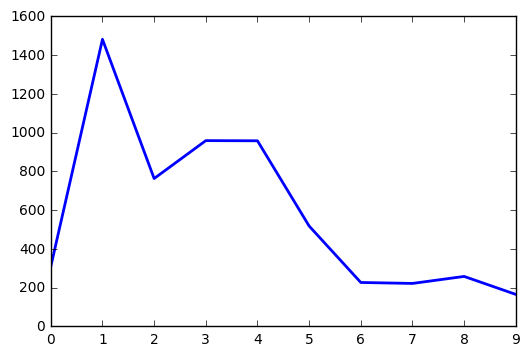

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [26]:
#First lets define a fucntion to represent the topology of our Neuronal Network:
#Topology: Multilayer Perceptron, 1 hidden layer with 1024 neurons and RELU activation function.

def mlp2(x, weights, biases,l2=0,drop_out="N",keep_prob=1):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    if(l2==0 and drop_out=="N"):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    if(l2>0 and drop_out=="N"):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['h1']))
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['out']))
    if(l2==0 and drop_out=="Y"):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #now we shutdown some neurons outputs and scale the rest by a factor of 1 + (1-keep_prob) = 2-keep_prob
        h1_layer = tf.nn.dropout(h1_layer,keep_prob)*(2-keep_prob) 
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    if(l2>0 and drop_out=="Y"):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #now we shutdown some neurons outputs and scale the rest by a factor of 1 + (1-keep_prob) = 2-keep_prob
        h1_layer = tf.nn.dropout(h1_layer,keep_prob)*(2-keep_prob) 
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['h1']))
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['out']))
    
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [38]:
#hyper-parameters

batch_size = 128
training_epochs = 3001
learning_rate = 0.5
display_step = 500
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels
l2 = 0.0001
keep_prob = 0.9 #this is 1 - dropout rate. So, if I want 0.2 dropout probability I use 0.8 of keep_prob

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp2(tf_train_dataset, weights, biases,l2,drop_out="Y",keep_prob=keep_prob)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp2(tf_valid_dataset,weights,biases,l2=l2,drop_out="N")) #only apply dropout during training
    test_prediction = tf.nn.softmax(mlp2(tf_test_dataset,weights,biases,l2=l2,drop_out="N")) #only apply dropout during training
    

Graph Variables Initialized!
Minibatch loss at step 0: 376.112426758
Minibatch accuracy: 10.15625
Validation accuracy: 31.0
Minibatch loss at step 500: 15.837141037
Minibatch accuracy: 80.46875
Validation accuracy: 80.72
Minibatch loss at step 1000: 10.9723367691
Minibatch accuracy: 85.15625
Validation accuracy: 80.02
Minibatch loss at step 1500: 10.4364070892
Minibatch accuracy: 80.46875
Validation accuracy: 77.8
Minibatch loss at step 2000: 7.08001041412
Minibatch accuracy: 78.90625
Validation accuracy: 81.8
Minibatch loss at step 2500: 5.04674243927
Minibatch accuracy: 85.15625
Validation accuracy: 80.72
Minibatch loss at step 3000: 2.61497545242
Minibatch accuracy: 81.25
Validation accuracy: 81.6
Test accuracy: 88.26


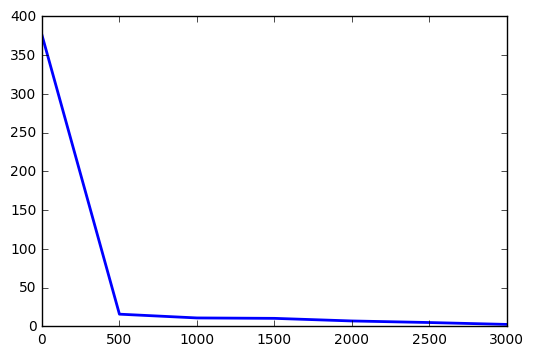

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


# First, 1 layers, no regularization, batch training

In [16]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [17]:
def multilayer_p(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    #h1 layer z = XW + b
    h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    #h1 layer activation function relu(z)
    h1_layer = tf.nn.relu(h1_layer)
    #output layer (no activation needed after output layer)
    out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [18]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

train_subset = 10000
image_size = 28
num_labels = 10
n_imput = image_size*image_size
num_steps = 11
display_step = 1
learning_rate = 0.5
n_hidden_1 = 256


graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = multilayer_p(tf_train_dataset,weights,biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_p(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(multilayer_p(tf_test_dataset,weights,biases))

In [19]:
with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % display_step == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
        # Calling .eval() on valid_prediction is basically like calling run(), but
        # just to get that one numpy array. Note that it recomputes all its graph
        # dependencies.
        print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 181.722061
Training accuracy: 6.6%
Validation accuracy: 36.6%
Loss at step 1: 208.635986
Training accuracy: 36.6%
Validation accuracy: 36.5%
Loss at step 2: 250.484406
Training accuracy: 36.9%
Validation accuracy: 40.2%
Loss at step 3: 151.815582
Training accuracy: 40.9%
Validation accuracy: 49.8%
Loss at step 4: 78.494614
Training accuracy: 49.8%
Validation accuracy: 65.0%
Loss at step 5: 40.019680
Training accuracy: 65.8%
Validation accuracy: 71.5%
Loss at step 6: 26.947613
Training accuracy: 72.3%
Validation accuracy: 73.5%
Loss at step 7: 27.941019
Training accuracy: 73.9%
Validation accuracy: 75.0%
Loss at step 8: 21.756683
Training accuracy: 76.3%
Validation accuracy: 75.8%
Loss at step 9: 19.972481
Training accuracy: 77.0%
Validation accuracy: 76.1%
Loss at step 10: 18.750132
Training accuracy: 77.1%
Validation accuracy: 76.1%
Test accuracy: 84.2%


# Second try, 2 layers, no regularization, mini-batch training

In [35]:
def multilayer_p2(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    #h1 layer z = XW + b
    h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    #h1 layer activation function relu(z)
    h1_layer = tf.nn.relu(h1_layer)
    #output layer (no activation needed after output layer)
    
    h2_layer = tf.add(tf.matmul(h1_layer,weights['h2']), biases['b2'])
    h2_layer = tf.nn.relu(h2_layer)
    
    out_layer = tf.add(tf.matmul(h2_layer,weights['out']), biases['out'])
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [38]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

batch_size = 128
train_subset = 10000
image_size = 28
num_labels = 10
n_imput = image_size*image_size
num_steps = 3001
display_step = 100
learning_rate = 0.001
n_hidden_1 = 1024
n_hidden_2 = 512



graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    
    
    #tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    #tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1,n_hidden_2])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([num_labels]))
    }

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = multilayer_p2(tf_train_dataset,weights,biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
     

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
       
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_p2(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(multilayer_p2(tf_test_dataset,weights,biases))

Initialized
Minibatch loss at step 0: 5192.82861328
Minibatch accuracy: 10.9375
Validation accuracy: 10.76
Minibatch loss at step 100: 628.991882324
Minibatch accuracy: 64.84375
Validation accuracy: 71.0
Minibatch loss at step 200: 219.382751465
Minibatch accuracy: 82.8125
Validation accuracy: 74.36
Minibatch loss at step 300: 393.892700195
Minibatch accuracy: 78.125
Validation accuracy: 74.8
Minibatch loss at step 400: 359.992706299
Minibatch accuracy: 78.90625
Validation accuracy: 76.2
Minibatch loss at step 500: 358.429748535
Minibatch accuracy: 73.4375
Validation accuracy: 76.8
Minibatch loss at step 600: 365.354095459
Minibatch accuracy: 78.125
Validation accuracy: 77.36
Minibatch loss at step 700: 304.363555908
Minibatch accuracy: 75.78125
Validation accuracy: 77.48
Minibatch loss at step 800: 405.116394043
Minibatch accuracy: 71.875
Validation accuracy: 76.56
Minibatch loss at step 900: 199.693603516
Minibatch accuracy: 82.03125
Validation accuracy: 77.84
Minibatch loss at step 

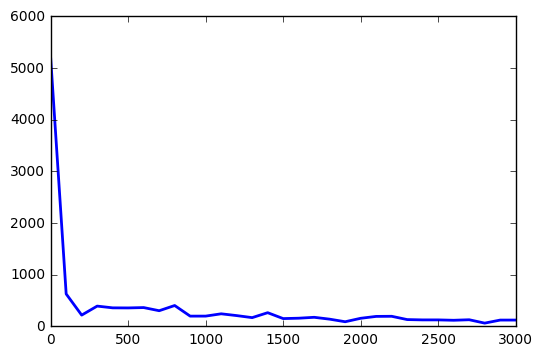

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

mycost = []
epoch = []

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        #_, l, predictions = session.run([optimizer, loss, train_prediction])
        
        if (step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

# Third try, same topology, adding learning decay

In [65]:
def multilayer_p2(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    #h1 layer z = XW + b
    h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    #h1 layer activation function relu(z)
    h1_layer = tf.nn.relu(h1_layer)
    #output layer (no activation needed after output layer)
    
    h2_layer = tf.add(tf.matmul(h1_layer,weights['h2']), biases['b2'])
    h2_layer = tf.nn.relu(h2_layer)
    
    out_layer = tf.add(tf.matmul(h2_layer,weights['out']), biases['out'])
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [94]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

batch_size = 128
train_subset = 10000
image_size = 28
num_labels = 10
n_imput = image_size*image_size
num_steps = 3001
display_step = 100
#initial_learning_rate = 0.001
initial_learning_rate = 0.002
n_hidden_1 = 1024
n_hidden_2 = 512
decay_steps = 100
decay_rate = 0.98



graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    
    
    #tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    #tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    #graph variables
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    increment_global_step_op = tf.assign(global_step, global_step+1)
    
    learning_rate = tf.train.exponential_decay(initial_learning_rate,global_step,decay_steps=decay_steps, decay_rate=decay_rate)
    
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1,n_hidden_2])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([num_labels]))
    }

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = multilayer_p2(tf_train_dataset,weights,biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
     

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=increment_global_step_op)
       
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_p2(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(multilayer_p2(tf_test_dataset,weights,biases))

Initialized
Minibatch loss at step 0: 4752.72705078
Minibatch learning rate 0.00199959613383
Minibatch accuracy: 10.9375
Validation accuracy: 20.9
Minibatch loss at step 100: 574.153076172
Minibatch learning rate 0.00192041217815
Minibatch accuracy: 64.84375
Validation accuracy: 73.1
Minibatch loss at step 200: 287.211914062
Minibatch learning rate 0.00184436386917
Minibatch accuracy: 80.46875
Validation accuracy: 75.56
Minibatch loss at step 300: 391.690948486
Minibatch learning rate 0.00177132710814
Minibatch accuracy: 75.78125
Validation accuracy: 77.14
Minibatch loss at step 400: 282.073577881
Minibatch learning rate 0.00170118268579
Minibatch accuracy: 82.03125
Validation accuracy: 77.72
Minibatch loss at step 500: 378.047912598
Minibatch learning rate 0.0016338158166
Minibatch accuracy: 76.5625
Validation accuracy: 78.42
Minibatch loss at step 600: 233.945068359
Minibatch learning rate 0.00156911695376
Minibatch accuracy: 79.6875
Validation accuracy: 78.46
Minibatch loss at step 

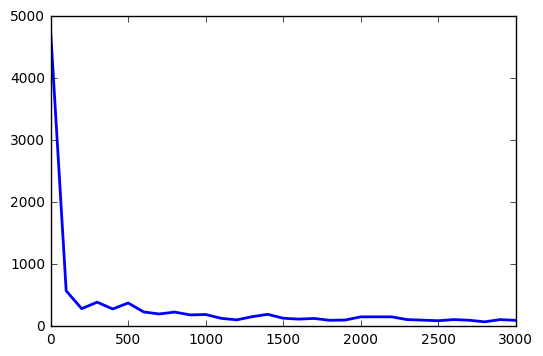

In [95]:
%matplotlib inline

import matplotlib.pyplot as plt

mycost = []
epoch = []


with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
                
        #learning_rate = tf.train.exponential_decay(initial_learning_rate,global_step,decay_steps=decay_steps, decay_rate=decay_rate)
        
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels}
        
        _, l, predictions,_,lr = session.run([optimizer, loss, train_prediction, increment_global_step_op,learning_rate], feed_dict=feed_dict)
        
        
        if (step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch learning rate {}".format(lr))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

# Fourth Try, More layers, more neurons, learning decay rate (using Adam Optimizer)

In [99]:
def multilayer_p3(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    #h1 layer z = XW + b
    h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    #h1 layer activation function relu(z)
    h1_layer = tf.nn.relu(h1_layer)
    #output layer (no activation needed after output layer)
    
    h2_layer = tf.add(tf.matmul(h1_layer,weights['h2']), biases['b2'])
    h2_layer = tf.nn.relu(h2_layer)
    
    h3_layer = tf.add(tf.matmul(h2_layer,weights['h3']), biases['b3'])
    h3_layer = tf.nn.relu(h3_layer)
    
    out_layer = tf.add(tf.matmul(h3_layer,weights['out']), biases['out'])
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [107]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

batch_size = 512
train_subset = 10000
image_size = 28
num_labels = 10
n_imput = image_size*image_size
num_steps = 5001
display_step = 100
learning_rate = 0.001
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256




graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1,n_hidden_2])),
        'h3': tf.Variable(tf.truncated_normal([n_hidden_2,n_hidden_3])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_3,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'b3': tf.Variable(tf.zeros([n_hidden_3])),
        'out': tf.Variable(tf.zeros([num_labels]))
    }

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = multilayer_p3(tf_train_dataset,weights,biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
     

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
       
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_p3(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(multilayer_p3(tf_test_dataset,weights,biases))

Initialized
Minibatch loss at step 0: 56617.125
Minibatch accuracy: 10.546875
Validation accuracy: 12.2
Minibatch loss at step 100: 3713.67407227
Minibatch accuracy: 76.3671875
Validation accuracy: 74.44
Minibatch loss at step 200: 2829.4543457
Minibatch accuracy: 76.3671875
Validation accuracy: 76.78
Minibatch loss at step 300: 2282.42138672
Minibatch accuracy: 76.171875
Validation accuracy: 78.06
Minibatch loss at step 400: 1807.83361816
Minibatch accuracy: 80.078125
Validation accuracy: 77.66
Minibatch loss at step 500: 1333.15917969
Minibatch accuracy: 80.859375
Validation accuracy: 78.9
Minibatch loss at step 600: 1006.53112793
Minibatch accuracy: 81.640625
Validation accuracy: 78.58
Minibatch loss at step 700: 888.672912598
Minibatch accuracy: 83.3984375
Validation accuracy: 79.48
Minibatch loss at step 800: 1028.84545898
Minibatch accuracy: 82.03125
Validation accuracy: 79.44
Minibatch loss at step 900: 674.090881348
Minibatch accuracy: 85.546875
Validation accuracy: 79.68
Minib

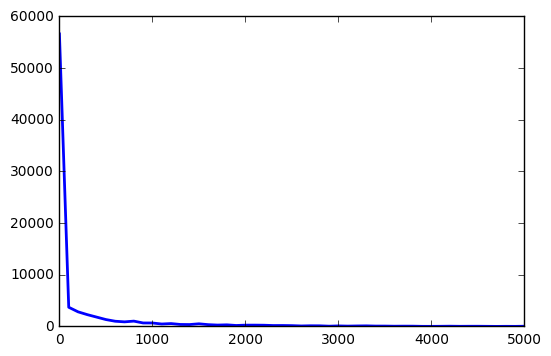

In [108]:
%matplotlib inline

import matplotlib.pyplot as plt

mycost = []
epoch = []

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        #_, l, predictions = session.run([optimizer, loss, train_prediction])
        
        if (step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)